# Loss Function and Robustness in Data-Fitting

## Technical Setup

### NAG Library
To run this notebook, you will need to install the NAG Library for Python (Mark 28.5 or newer) and a license key. You can find the software and request a license key from our website here: https://www.nag.com/content/getting-started-nag-library?lang=py&os=linux

### Correct Rendering of this notebook

This notebook makes use of the `latex_envs` Jupyter extension for equations and references.  If the LaTeX is not rendering properly in your local installation of Jupyter, it may be because you have not installed this extension.  See at https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html for further information.

## Introduction
Fitting a non-linear model to data is typically modelled as a minimisation problem, where the objective function serves as a measurement of the quality of the model’s fit to data, depending on our parameters. A general model involves summing over our data points,

$$
\underset{x \in \mathbb{R}^{n_{\text{var}}}}{\text{minimize}} ~f(x) =\sum_{i=1}^{n_{\text{res}}} \chi(r_i(x)),
$$

where $x$ is a vector holding our model parameters, of which there are $n_\text{var}$. We have $n_\text{res}$ data points, and $r_i(x)= y_i - \varphi(t_i;x), \quad i = 1,...,n_\text{res}$ is the $i^{th}$ residual, equal to the difference between the observed and predicted values of the independent variable at time $t_i$, denoted $y_i$ and $\varphi(t_i;x)$ respectively. The loss function $\chi$ has desirable properties such as being bounded from below, and increasing with $|r_i\left(x\right)|$. Summing over all data points then, the objective function will be small when the model fits the whole dataset well, which is what we want.

There are plenty of choices for function $\chi$, so how does our choice of loss function affect the fit we end up with? One important consideration is robustness. If some of the observed data points are far from the fitted model, how can we control the influence of those outliers? A robust loss function is one which doesn’t get thrown off easily by outliers in the data.

In [1]:
# import all packages necessary for notebook
import numpy as np
import matplotlib.pyplot as plt
from naginterfaces.base import utils
from naginterfaces.library import opt

## Single-outlier example

To investigate the robustness aspect, here’s a toy dataset which is generated from $\sin(t)$ and has an outlier at $t=1.5$, which is generated by $5\sin(t)$.

In [2]:
# create data set
t = np.linspace(0.5, 2.5, num=21)
y = np.sin(t)
y[10] = 5*np.sin(t[10])

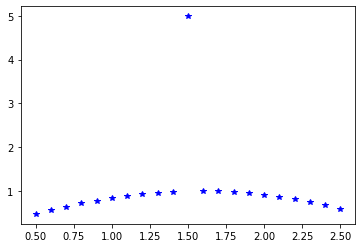

In [3]:
fig1 = plt.plot(t,y,'*b')

We will fit it with a model 

$$
\varphi(t;x)\ =x_1\sin(x_2t)
$$

using a variety of loss functions provided by NAG’s data-fitting solver **handle_solve_nldf** (`e04gn`), which constructs the appropriate objective function for us.

In [4]:
# create a handle for the model
nvar = 2
handle = opt.handle_init(nvar=nvar)

In [5]:
# register residuals structure
nres = 21
opt.handle_set_nlnls(handle, nres)

In [6]:
# define the residual callback function and its gradient
def lsqfun(x, nres, inform, data):
    rx = np.zeros(nres,dtype=float)
    t = data["t"]
    y = data["y"]
    for i in range(nres):
        rx[i] = (y[i] - x[0]*np.sin(x[1]*t[i]))
        
    return rx, inform

def lsqgrd(x, nres, rdx, inform, data):
    t = data["t"]
    nvar = len(x)
    for i in range(nres):
        rdx[i*nvar] = (-np.sin(x[1]*t[i]))
        rdx[i*nvar + 1] = (-t[i]*x[0]*np.cos(x[1]*t[i]))

    return inform

In [7]:
# create the data structure to be passed to the solver
data = {}
data["t"] = t
data["y"] = y

### Start with $l_2$-norm loss function - Example 1
Starting with one of the most common loss functions, the $l_2$-norm, we form the problem

$$
\underset{x \in \mathbb{R}^{2}}{\text{minimize}}~f(x) =\sum_{i=1}^{21} r_i(x)^2
$$

which is just least squares regression. $l_2$-norm loss has low robustness against outliers, so we should expect that the solution will be affected heavily by this one outlier. Let’s solve from a starting point at

$$
x\ =\ (2.1,1.4)
$$

to see what this outlier does to the minimum.

In [8]:
# set loss function to l2-norm and printing options
for option in [
    'NLDF Loss Function Type = L2',
    'Print Level = 1',
    'Print Options = No',
    'Print solution = Yes'
]:
    opt.handle_opt_set (handle, option)

# use an explicit I/O manager for abbreviated iteration output:
iom = utils.FileObjManager(locus_in_output=False)

In [9]:
# set initial guess and solve
x = [2.1, 1.4]
soln1 = opt.handle_solve_nldf(
    handle, lsqfun, lsqgrd, x, nres, data=data, io_manager=iom)

 E04GN, Nonlinear Data-Fitting
 Status: converged, an optimal solution found
 Final objective value  1.470963E+01

 Primal variables:
   idx   Lower bound       Value       Upper bound
     1       -inf       1.30111E+00         inf
     2       -inf       1.06956E+00         inf


In [10]:
# calculate fitted data using the optimal parameters
y_l2_fitted = soln1.x[0]*np.sin(soln1.x[1]*t)

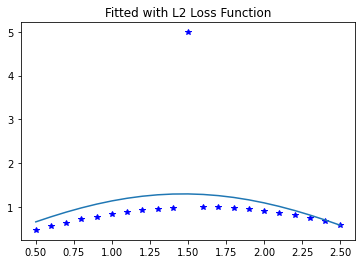

In [11]:
# plot the fitted curve
plt.title("Fitted with L2 Loss Function")
plt.plot(t,y,'*b')
plt.plot(t,y_l2_fitted)
plt.show()

The single outlier was able to disrupt the fit, since $l_2$-norm loss makes outliers contribute heavily to the objective function and search direction.

### Try $l_1$-norm loss function - Example 2
Using $l_1$-norm loss gives us the problem

$$
\underset{x \in \mathbb{R}^{2}}{\text{minimize}}~f(x) =\sum_{i=1}^{21} |r_i(x)|,
$$

which is more robust against outliers. This means if some large portion of the data is well-fitted by some solution $x^\ast$, there is likely to be a local minimum very close to $x^\ast$ which is relatively undisturbed by the remaining data that is outlying to the solution $x^\ast$. Here’s the solution, again starting at $x=(2.1,1.4)$, using $l_1$ loss.

In [12]:
# change loss function to l1-norm and solve
opt.handle_opt_set(handle, 'NLDF Loss Function Type = L1')
soln2 = opt.handle_solve_nldf(
    handle, lsqfun, lsqgrd, x, nres, data=data, io_manager=iom)

 E04GN, Nonlinear Data-Fitting
 Status: converged, an optimal solution found
 Final objective value  3.989980E+00

 Primal variables:
   idx   Lower bound       Value       Upper bound
     1       -inf       1.00000E+00         inf
     2       -inf       1.00000E+00         inf


In [13]:
# calculate fitted data using the optimal parameters
y_l1_fitted = soln2.x[0]*np.sin(soln2.x[1]*t)

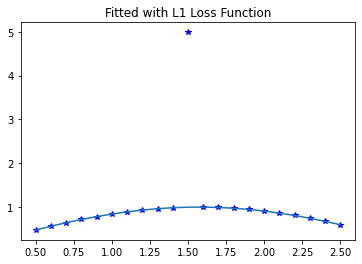

In [14]:
# plot the fitted curve
plt.title("Fitted with L1 Loss Function")
plt.plot(t,y,'*b')
plt.plot(t,y_l1_fitted)
plt.show()

Clearly, this is a much better fit for most of the data, and the outlier hasn’t dragged the model off most of the data.

## The trade-off of a loss function

We can reuse the handle, the residual function (and gradient). Just changing the data and options, we can demonstrate more principles to consider regarding loss functions.

There is a danger in choosing a very robust loss function. During an iterative optimization process, a loss function which is robust against outliers will usually prefer the data which is close to the current model. This means that if the algorithm finds local minima of the objective function, the search can fall into a local minimum when the model fits some subset of the data very well but fits the majority of the data very badly.

To illustrate this, here’s a new dataset which we will try to fit with the same model, again starting at $x= (2.1,1.4)$. Most of the data was generated by $5\sin(t)$, with the 3 data points at either end being generated by $\sin(t)$.

In [15]:
# create the data set
y_new = y
for i in range(3,18):
    y_new[i] = 5*np.sin(t[i])

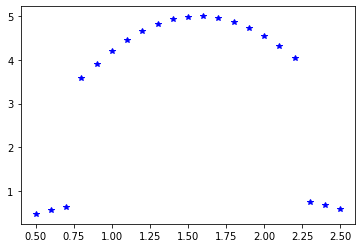

In [16]:
plt.plot(t,y_new,'*b')
plt.show()

In [17]:
# recreate the data structure to be passed to the solver
data_new = {}
data_new["t"] = t
data_new["y"] = y_new

We will fit this data set using 3 different loss functions with the same model $\varphi(t;x)$ each time and discuss the results under the plots all at once below.

### Fit model with the $l_2$-norm, $l_1$-norm and Arctan loss function

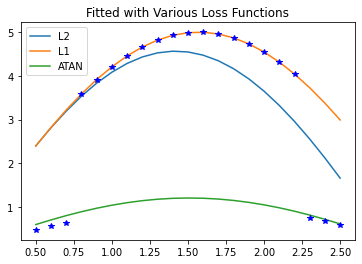

In [18]:
loss_functions = ['L2', 'L1', 'ATAN']

# turn off printing of solver log
opt.handle_opt_set(handle, 'print file = -1')

# solve using 3 different loss functions
for lfunc in loss_functions:
    
    # set option for loss function and solve
    opt.handle_opt_set(handle, 'NLDF Loss Function Type =' + lfunc)
    soln = opt.handle_solve_nldf(
        handle, lsqfun, lsqgrd, x, nres, data=data_new, io_manager=iom)
    # plot fitted curve
    plt.plot(t, soln.x[0]*np.sin(soln.x[1]*t), label=lfunc)

# plot data points   
plt.plot(t,y_new,'*b')
plt.title("Fitted with Various Loss Functions")
plt.legend()
plt.show()

### Fitted Models and Contour Plots

In the first row of plots, the data is fitted using $l_2$-norm loss, $l_1$-norm loss, and $\arctan$ loss. Shown below each is the contour plot of the objective function value, where the black circles represent the parameters used to generate the data, the cyan circles represents the starting point for the solver, and the cyan wedges represent the optimized solution found by the solver.

![Contour](nldf_contour.png)

In the $l_2$-norm case in the left column, the outliers generated by $\sin(t)$ have pulled the optimal solution away from $x = (5,1)$. The contour plot for $l_2$-norm loss indicates that we don’t have to worry too much about what starting point to use, since there are no local minima in the region displayed, other than global best solution.

The behaviour of the solver is quite different when using an extremely robust loss function like $\arctan$ loss, which looks like

$$
\underset{x \in \mathbb{R}^{2}}{\text{minimize}} ~ f(x) =\sum_{i=1}^{21} \text{arctan}(r_i(x)^2)
$$

The fitted model and corresponding contour plot for the $\arctan$ case are in the middle. Here, there are eight local minima in the contour plot for $\arctan$ loss, with seven of them being substantially worse solutions than the global minimum, and it is one of these we’ve converged to. Therefore, in this case the selection of initial estimation of the parameters is much more important.

The model fitted with $l_1$-norm loss and the corresponding contour plot are in the right column. Looking at the contour plot, there are still a few local minima that do not correspond to the optimal solution, but the starting point of $x = (2.1,1.4)$ still converges to the global minimum, which lies at
$x = (5,1)$, meaning the part of the dataset generated from $\sin(t)$ is effectively being ignoring. From the plots of the loss functions, we can see that $l_1$-norm loss is more robust than $l_2$-norm loss but less so than $\arctan$ loss. 

So, what has happened in each case is: using $l_2$-norm loss, we move to the global minimum which is affected by the whole dataset. Using $l_1$-norm loss, we move to the global minimum which fits most of the data very well and ignores a small portion, treating them as outliers. Using $\arctan$ loss we move to a local minimum which ignores a large portion of the data (treating them as outliers) and fits a small amount of data very well.

## Conclusion

The lesson here is that the same thing that makes a loss function robust – ignoring data that lies far from the current model to some degree – can populate the search space with local minima where the model predicts some of the data well and ignores most of it. In extreme cases like arctan loss, if the starting point fits some of the data very well, the model will likely just be optimized for that portion of the data, even if it is a small portion of the whole dataset. It is therefore important to try a variety of loss functions and stating points when setting up a data-fitting problem, since these will affect both the optimal solution, as well as how easily an optimal solution is found.